In [14]:
!pip3 -qqq install transformers torch datasets

!pip3 -qqq install gdcm
!pip3 -qqq install pydicom
!pip -qqq install faiss-gpu
!pip -qqq install pinecone-client

In [16]:
import os
import faiss
import torch
import skimage
import requests
import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

In [17]:
def get_image(image_URL):
   response = requests.get(image_URL)
   image = Image.open(BytesIO(response.content)).convert("RGB")
   return image

In [18]:
def get_model_info(model_ID, device):
	# Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
	# Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
  # Return model, processor & tokenizer
	return model, processor, tokenizer

In [19]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [20]:
def get_single_image_embedding(my_image,processor, model, device):
  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
      )["pixel_values"].to(device)
  embedding = model.get_image_features(image)
  # convert the embeddings to numpy array
  return embedding.cpu().detach().numpy()

In [21]:
import json
import os

# Define your data structures using dataclasses
from dataclasses import dataclass
from typing import List

In [22]:
@dataclass
class Product:
    name: str
    url: str
    image: str
    price: str
    category: str

@dataclass
class SubSubCategory:
    name: str
    link: str
    category: str
    products: List[Product]

@dataclass
class Subcategory:
    name: str
    link: str
    category: str
    subsubcategory: List[SubSubCategory]

@dataclass
class Category:
    name: str
    link: str
    subcategory: List[Subcategory]

In [50]:
# Define the directory path
directory_path = './'

# List of files to read
categories = [
    "автотовары",
    "аксессуары",
    "аптека",
    "бытовая техника",
    "детские товары",
    "канцелярские товары",
    "компьютеры",
    "красота, здоровье",
    "мебель",
    "обувь",
    "одежда",
    "подарки, товары для праздников",
    "спорт,  туризм",
    "строительство, ремонт",
    "тв, аудио, видео",
    "телефоны и гаджеты",
    "товары для дома и дачи",
    "товары для животных",
    "украшения"
]

In [26]:
def check_valid_URL(image_URL):
    try:
        response = requests.get(image_URL)
        if response.status_code != 200:
            return False
        Image.open(BytesIO(response.content))
        return True
    except Exception:
        return False

In [55]:
def read_json_file(file_path: str):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Process each file
list_image_urls = []
list_metadatas = []
indexes = {}

for file_name in categories:
    file_path = os.path.join(directory_path, file_name + ".json")
    if os.path.exists(file_path):
        file_data = read_json_file(file_path)
        print(f"Top-level keys in {file_name}.json: {list(file_data.keys())}")
        subsubs = file_data.get('subsubcategory')
        if subsubs:

#
#   !!! GET ONLY COMPUTERS.
#
            if subsubs[0]['category'] != "Компьютеры":
              continue
            indexes[subsubs[0]['category']] = []
            print(subsubs[0]['category'])
            for subsub in subsubs:
                for product in subsub['products']:
                  if product['image'] != "":
                    list_image_urls.append(product['image'])
                    list_metadatas.append({
                        "name": product['name'],
                        "url": product['url'],
                        "price": product['price'],
                        "category": product['category']
                    })

        else:
            print(f"No 'subsubcategory' key found in {file_name}.json")
    else:
        print(f"File {file_path} does not exist")


Top-level keys in автотовары.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in аксессуары.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in аптека.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in бытовая техника.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in детские товары.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in канцелярские товары.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in компьютеры.json: ['name', 'link', 'category', 'subsubcategory']
Компьютеры
Top-level keys in красота, здоровье.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in мебель.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in обувь.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in одежда.json: ['name', 'link', 'category', 'subsubcategory']
Top-level keys in подарки, товары для праздников.json: ['name', 'link', 'catego

bjiuibbibui

In [56]:
from tqdm.notebook import tqdm

n = len(list_image_urls)
print(f"Processing {n} images...")

for i, val in tqdm(enumerate(list_image_urls), total=n, desc="Processing Images"):
    image = get_image(val)

    embedding = get_single_image_embedding(image, processor, model, device)

    category = list_metadatas[i]['category']
    indexes[category].append(embedding)

Processing 3858 images...


Processing Images:   0%|          | 0/3858 [00:00<?, ?it/s]

In [57]:
len(list_image_urls) == len(list_metadatas)

True

In [85]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="")

In [87]:
for key, value in indexes.items():
    dimension = 512
    index_name = key.lower()

    # if index_name not in pc.list_indexes():
        # pc.create_index(
        #     name=index_name,
        #     dimension=dimension,
        #     metric="cosine",
        #     spec=ServerlessSpec(
        #         cloud='gcp',
        #         region='us-central1'
        #     )
        # )
    index = pc.Index("kaspi")
    vectors = []
    for i in range(len(value)):
        # Flatten the value if it's a numpy array or nested list
        flat_values = list(value[i].flatten()) if hasattr(value[i], 'flatten') else list(value[i])

        # Ensure all values are floats
        float_values = [float(v) for v in flat_values]

        vector = {
            "id": str(i),
            "values": float_values,
            "metadata": list_metadatas[i]
        }
        vectors.append(vector)
        if len(vectors) >= 10:
            print(len(vectors))
            index.upsert(vectors=vectors, namespace="computers")
            vectors = []


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

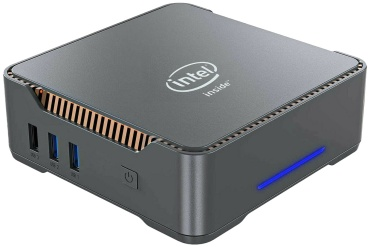

In [128]:
test = get_image("https://resources.cdn-kaspi.kz/img/m/p/h3f/hee/86668250677278.jpg?format=preview-large")
test

In [129]:
testembedings = get_single_image_embedding(test, processor, model, device)
testembedings_list = testembedings.tolist()
testresults = index.query(vector=testembedings_list, top_k=5, namespace="computers")


In [121]:
def extract_highest_score(match_data):
  # Ensure there are matches in the input data
  if 'matches' in match_data and isinstance(match_data['matches'], list) and len(match_data['matches']) > 0:
      # Find the match with the highest score
      highest_score_match = max(match_data['matches'], key=lambda x: x['score'])

      # Extract the required keys for the highest score
      result = {
          'id': highest_score_match['id'],
          'score': highest_score_match['score'],
          'image_url': highest_score_match['metadata']['image']
      }
      return result
  else:
      return None

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
import requests

In [94]:
def plot_top_matches_seaborn(match_data):
    if 'matches' in match_data and isinstance(match_data['matches'], list) and len(match_data['matches']) > 0:
        # Sort the matches by score in descending order and take the top 3
        sorted_matches = sorted(match_data['matches'], key=lambda x: x['score'], reverse=True)[:3]

        # Create a grid for displaying the top 3 matches
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        for i, match in enumerate(sorted_matches):
            ax = axs[i]
            image_url = match['metadata']['image']
            id_val = match['id']
            score_val = match['score']

            # Load and display the image using Seaborn
            #response = requests.get(image_url)
            #img = Image.open(BytesIO(response.content))
            img = np.array(PIL.Image.open(urllib.request.urlopen(image_url)))
            #sns.heatmap([[0]], ax=ax, cbar=False, xticklabels=False, yticklabels=False)
            img = PIL.Image.fromarray(img).resize((300, 300))
            #img = img.resize((300, 300))
            ax.imshow(img)
            ax.set_title(f"ID: {id_val}\nScore: {score_val:.2f}")
            ax.axis('off')

        plt.show()
    else:
        print("No 'matches' found in the input data or the list is empty.")



In [138]:
images = []

for match in testresults['matches']:
  print(match)
  images.append(get_image(list_image_urls[int(match['id'])]))

{'id': '2270', 'score': 0.998666108, 'values': []}
{'id': '948', 'score': 0.866054118, 'values': []}
{'id': '2357', 'score': 0.858873069, 'values': []}
{'id': '2356', 'score': 0.85691756, 'values': []}
{'id': '2302', 'score': 0.855263591, 'values': []}


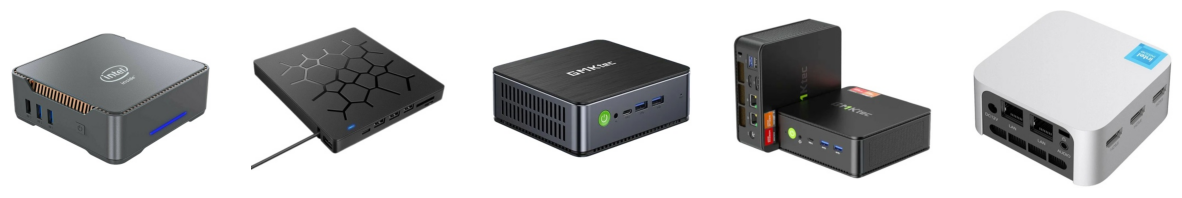

In [139]:
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')

plt.show()